In [17]:
%pylab inline

from xgboost.sklearn import XGBClassifier
from typing import Tuple
import xgboost as xgb
import pandas as pd
import json
import sklearn

dataset = pd.read_csv('data/multisession-eeg.csv')
fromstring = lambda array_str: np.fromstring(array_str, dtype=float, sep=',')
dataset.raw_fft = dataset.raw_fft.apply(fromstring)

column_names = ['number','time','value','label']
dataset0 = pd.read_csv('data/0.csv')
dataset0.columns = column_names

dataset1 = pd.read_csv('data/1.csv')
dataset1.columns = column_names

dataset2 = pd.read_csv('data/2.csv')
dataset2.columns = column_names

dataset3 = pd.read_csv('data/3.csv')
dataset3.columns = column_names

dataset.dtypes

#dataset.raw_fft.iloc[0]


Populating the interactive namespace from numpy and matplotlib


/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf', 'negative', 'fromstring']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


time       object
subject    object
session     int64
label      object
raw_fft    object
dtype: object

# Passthoughts

What if you could simply *think your password*? That's the premise behind *passthoughts*. We'll discuss passthoughts in more depth in lecture 3, but for now, we'll lay this out as a classification problem:

> Given a reading and a person, is that person who they claim to be?

We'll structure this problem as follows: For each subject, we'll train a classifier. That subject's readings will be positive example, and everyone else's readings will be negative examples. *Kaushiki - Essentially, A's thoughts vs B's and C's thoughts*

We can make this a little fancier by having people use specific thoughts (e.g. "focus on your breathing," "sing a song in your head," etc). We'll make sure our methods can handle this case, but for the time being, we'll just use the `"unlabeled"` readings - people doing nothing in particular.

We'll use subject `A` as our "target" individual. We will train on this subject for this assignment, and train against the other subjects in the corpus (subjects `B` and `C`).

In [3]:
def to_matrix (series):
    """Convert dataframe to matrix or np.array"""
    return np.array([ x for x in series])

def readings_right_subject_right_task (subj, task, session=0):
    """Filter dataset for the subject, task and session. Default session 0"""
    return to_matrix(dataset[
        (dataset['subject'] == subj) &
        (dataset['label'] == task) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_wrong_subj_any_task (subj):
    """Filter dataset for the subject other than the entered subject over all the tasks.
    Sessions doesn't matter as B and C don't have session 1 and session 2 data."""
    return to_matrix(dataset[
        (dataset['subject'] != subj)
    ].raw_fft)

def readings_right_subj_wrong_task (subj, task, session):
    """Filter dataset for the right subject, wrong task and right session."""
    return to_matrix(dataset[
        (dataset['subject'] == subj) &
        (dataset['label'] != task) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_wrong_subj_right_task (subj, task):
    """Filter dataset for the wrong subject, right task. Session 0"""
    return to_matrix(dataset[
        (dataset['subject'] != subj) &
        (dataset['label'] == task)
    ].raw_fft)


## TODO

Notice how we structured our positive and negative examples:

Case 1:
- *Positive examples*: The right person thinking the right task.

- *Negative examples*: The wrong person thinking any task (whether it is right or wrong).

In the context of passthoughts, consider other possibilites for selecting positive and negative features. Here, 
(1) pick one configuration of positive and negative examples, aside from the ones listed, and 
(2) discuss their possible consequences (pros/cons)

*Your answer here...*


Other possiblity of selecting positive and negative features can be
Case 2:
- *Positive examples*: The right person thinking the right task
- *Negative examples* The wrong person thinking the right task

Case 3:
- *Positive examples*: The right person thinking the right task
- *Negative examples* The right person thinking the wrong task

In [22]:
positive = readings_right_subject_right_task('A', 'unlabeled', 0)

#Case 1: PcTc vs PiTx
negative = readings_wrong_subj_any_task('A')

#Case 2: PcTc vs PiTc
#negative = readings_wrong_subj_right_task (right_person, right_task)

#Case 3: PcTc vs PcTi
#negative = readings_right_subj_wrong_task (right_person, right_task)

positive.shape, negative.shape

array([[ 10.31130409,  14.77069664,  12.21351433, ..., -17.47436905,
        -10.13802242,  -9.64999294],
       [ 11.21512699,  14.95685577,  10.83694172, ..., -18.60851669,
        -13.82363701, -12.32877541],
       [  6.34600163,  12.59247112,  10.84169102, ..., -21.45312691,
        -19.91650391, -21.89144516],
       ..., 
       [  7.67896748,   9.779562  ,   6.59336472, ..., -31.32478905,
        -27.52483749, -26.52264977],
       [  8.23083496,  13.19408035,  13.84129524, ..., -24.89140129,
        -22.43463516, -25.77708435],
       [  3.7469697 ,   8.20059395,   6.86803436, ..., -21.80238724,
        -22.58342361, -25.36535072]])

Now, we'll turn these data into our feature/label matrices `X` and `y`.

In [5]:
X = np.concatenate([positive, negative])

In [6]:
#Generate an array that has the actual results
y = np.array([0 for x in positive] + [ 1 for x in negative])
assert X.shape[0] == y.shape[0]

Note that we are assigning `0` to "positive" examples, and `1` to "negative" examples. That means `0` will mean "ACCEPT" and `1` will mean "REJECT."

Now, train and test a classifier! Estimate your classifier's accuracy.

In [7]:
def fresh_clf () -> XGBClassifier:
    return XGBClassifier(
        objective= 'binary:logistic',
        seed=27)

def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    #eval_metrics:
    #http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
    #metrics = [ 'auc' ]
    #we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    #the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

In [8]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

In [9]:
clf.score(X_validate, y_validate)

0.98329355608591884

For authentication, what we want even more than "accuracy" here are two metrics:

- False Acceptance Rate (FAR): The percentage of readings *not* from subject A incorrectly classified "ACCEPT."
- False Rejection Rate (FRR): The percentage of readings *from* subject A incorrectly classified 'REJECT."

For authentication /security/, we want FAR to be as low as possible (so nobody can break in).
For authentication /usability/, we want FRR to be low (so user's don't get frustrated constantly re-trying their passthought).

In [10]:
def far_frr (classifier, features, labels):
    #predict all the labels
    y_pred = classifier.predict(features)
    false_accepts = 0
    false_rejects = 0
    for predicted, actual in zip(y_pred, labels):
        #if we should have rejected, but in fact accepted:
        if (actual == 1) and (predicted == 0):
            #increment false accepts
            false_accepts += 1
        #if we should have accepted, but in fact rejected:
        if (actual == 0) and (predicted == 1):
            #increment false rejections
            false_rejects += 1
    #calculate proportions for FAR and FRR
    far = false_accepts / len(list(filter(lambda x: x==0, y_pred)))
    frr = false_rejects / len(list(filter(lambda x: x==1, y_pred)))
    return far, frr

In [11]:
far, frr = far_frr(clf, X_validate, y_validate)
f'FAR: {far} - FRR: {frr}'

'FAR: 0.3 - FRR: 0.009779951100244499'

Now, these results might be good. 

But our classifier's accuracy could be misleading.   

Can you see why? 

# Nonstationarity

We are training, and testing, using data recorded over a single session. As we know, EEG changes over time, a property known as *nonstationarity*. Will our great results still hold a few weeks later?

Let's take subject `A`'s data from sessions 1 and 2, which were recorded a few weeks after session 0.

In [12]:
X_subja_sess1 = readings_right_subject_right_task('A', 'unlabeled', 1)
X_subja_sess2 = readings_right_subject_right_task('A', 'unlabeled', 2)
X_subja_later = np.concatenate([X_subja_sess1, X_subja_sess2])
y_subja_later = [ 0 for x in X_subja_later ]

#previous y = np.array([0 for x in positive] + [ 1 for x in negative])

Now, let's try the classifier we trained on the original data, testing it on the later data.

In [13]:
far, frr = far_frr(clf, X_subja_later, y_subja_later)
f'FAR: {far*100}% - FRR: {frr*100}%'

'FAR: 0.0% - FRR: 100.0%'

As we will discuss more in lecture 3, this is a problem for us. After all, we can calibrate our target subject, but we then expect them to leave the lab and go use the device later on. If their state changes so much that they can no longer be authenticated, we can't very well claim our system is accurate!

## TODO

The crux of the lab focuses on nonstationarity. At minimum, your mission is to quantify and qualify *what* is changing in EEG signals over time. You may use any tools in answering this question.

You also have your choice of corpus:

- Study subject `A`'s recordings over the three sessions provided here.
- Study one subject's recordings over the course of a year.

You can use both of these corpora, if you would like.

Some questions to spur investigation:

- What features of readings cause a classifier that works on earlier recordings fail on later ones?
- What features remain the same? Are there any?
- What might be the source of these changing features? Changing placement in the EEG device? Changing properties of the brain?

Please note below all work you do, and any notes you make along the way. Ideally, your work should read like a story - words (and questions!) interspersed with code. Good luck, and have fun!

Quantify what is changing in EEG signals over time

What features of readings cause a classifier that works on earlier recordings fail on later ones?
What features remain the same? Are there any?

## Study subject A's recordings over three sessions

1) Study the behavior of inter-session FAR and FRR when session 1 and session 2 data is used to train the classifier

2) Scale the data

3) Study the behavior over scaled data


In [21]:
negative = readings_wrong_subj_any_task('A')
def session_estimates(session):
    positive = readings_right_subject_right_task('A', 'unlabeled', session)
    
    X = np.concatenate([positive, negative])
    y = np.array([0 for x in positive] + [ 1 for x in negative])
    assert X.shape[0] == y.shape[0]

    X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, test_size=0.33, 
    random_state=42)
    clf, cvres = xgb_cross_validate(X_train, y_train)
    far1, frr1 = far_frr(clf, X_validate, y_validate)
    X_subja_later = to_matrix(dataset[
        (dataset['subject'] == 'A') &
        (dataset['label'] == 'unlabeled') &
        (dataset['session'] != session)
    ].raw_fft)
    y_subja_later = [ 0 for x in X_subja_later ]
    far2, frr2 = far_frr(clf, X_subja_later, y_subja_later)
    return '{:.5f}  {:.5f}        {:.1f}   {:.1f}'.format(far1, frr1, far2, frr2)

print("   session#     FAR1     FRR2          FAR2     FRR2 (Inter-session)")
[('session '+str(session), session_estimates(session)) for session in range(0,3)]

   session#     FAR1     FRR2          FAR2     FRR2 (Inter-session)


[('session 0', '0.30000  0.00978        0.0   1.0'),
 ('session 1', '0.02532  0.00241        0.0   1.0'),
 ('session 2', '0.05128  0.00743        0.0   1.0')]

The above results show that the same-session FAR and FRR become better when session 1 data (and session 2 data later) is used to train the classifier. This is expected as the session 1 and session 2 data for subject 'A' is significantly larger (267 and 349 rows respectively) than session 0 data of only 40 unlabeled instances.

The behavior of inter-session FAR and FRR is the same across all sessions i.e. FAR2 

To investigate further, 
We can look into the Raw FFT -> mean and standard deviation for each session.

In [31]:
a0 = readings_right_subject_right_task('A', 'unlabeled', 0)
a1 = readings_right_subject_right_task('A', 'unlabeled', 1)
a2 = readings_right_subject_right_task('A', 'unlabeled', 2)

mean_s0 = np.mean(a0, axis=0)
mean_s1 = np.mean(a1, axis=0)
mean_s2 = np.mean(a2, axis=0)

std_a0 = np.std(a0, axis=0)
std_a1 = np.std(a1, axis=0)
std_a2 = np.std(a2, axis=0)

a0.shape, mean_s0.shape, std_a0.shape
#other values that can be considered - median and standard error of mean (sem)

((40, 516), (516,), (516,))

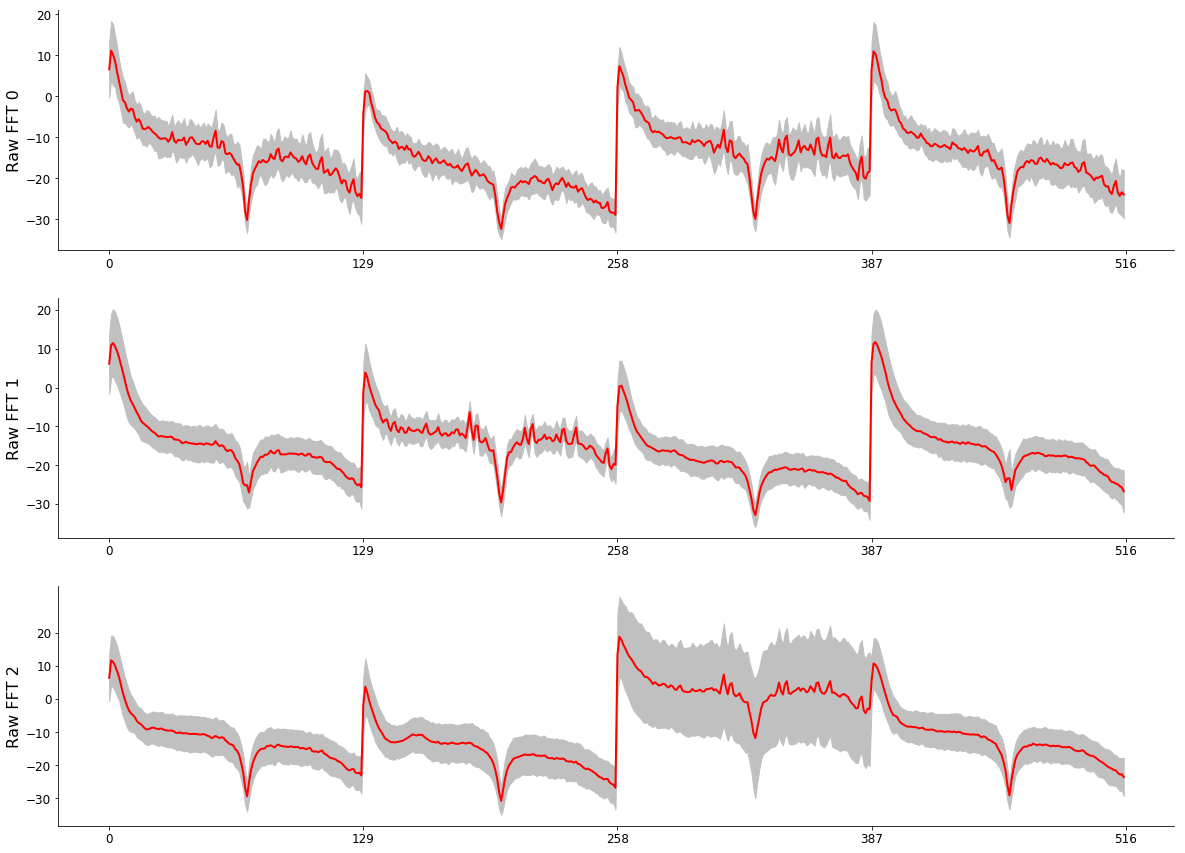

In [97]:
figure(figsize=(20, 15))  
ax0 = subplot(3,1,1)  
ax0.spines["top"].set_visible(False)  
ax0.spines["right"].set_visible(False) 
ax0.get_xaxis().tick_bottom()  
ax0.get_yaxis().tick_left()
xticks(range(0, 520, 129), fontsize=12) 
yticks(range(-50, 30, 10), fontsize=12)
ylabel("Raw FFT 0", fontsize=16)  
##3F5D7D
fill_between(np.arange(516), mean_s0 - std_a0, mean_s0 + std_a0, color="silver")  
plot(range(0,516), mean_s0, color="red", lw=2)

ax1 = subplot(3,1,2)
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False) 
ax1.get_xaxis().tick_bottom()  
ax1.get_yaxis().tick_left()
xticks(range(0, 520, 129), fontsize=12)   
yticks(range(-50, 30, 10), fontsize=12)
ylabel("Raw FFT 1", fontsize=16)  
fill_between(np.arange(516), mean_s1 - std_a1, mean_s1 + std_a1, color="silver")  
plot(range(0,516), mean_s1, color="red", lw=2)

ax2 = subplot(3,1,3)
ax2.spines["top"].set_visible(False)  
ax2.spines["right"].set_visible(False) 
ax2.get_xaxis().tick_bottom()  
ax2.get_yaxis().tick_left()
xticks(range(0, 520, 129), fontsize=12)    
yticks(range(-50, 30, 10), fontsize=12)
ylabel("Raw FFT 2", fontsize=16)  
fill_between(np.arange(516), mean_s2 - std_a2, mean_s2 + std_a2, color="silver")  
plot(range(0,516), mean_s2, color="red", lw=2)

The standard deviation over the sessions is increasing. The shape for the four channels is similar.

In [98]:
def scaled_session_estimates(session):
    positive = readings_right_subject_right_task('A', 'unlabeled', session)
    X = np.concatenate([positive[0:129], negative])
    y = np.array([0 for x in positive] + [ 1 for x in negative])
    assert X.shape[0] == y.shape[0]
    
    X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(X, y, 
    test_size=0.33, random_state=42)
    
    #sklearn.preprocessing.normalize(X, norm='l2')
    #robust_scaler = sklearn.preprocessing.RobustScaler()
    #X_train_scaled = robust_scaler.fit_transform(X_train)
    #X_validate_scaled = robust_scaler.transform(X_validate)
    
    #quantile = sklearn.preprocessing.QuantileTransformer(random_state=0)
    #X_train_scaled = quantile.fit_transform(X_train)
    #X_validate_scaled = quantile.transform(X_validate)

    clf, cvres = xgb_cross_validate(X_train, y_train)
    far1, frr1 = far_frr(clf, X_validate, y_validate)
    
    X_subja_later = to_matrix(dataset[
        (dataset['subject'] == 'A') &
        (dataset['label'] == 'unlabeled') &
        (dataset['session'] != session)
    ].raw_fft)
    y_subja_later = [ 0 for x in X_subja_later ]
    #X_subja_later_scaled = robust_scaler.transform(X_subja_later)
    
    far2, frr2 = far_frr(clf, X_subja_later, y_subja_later)
    return '{:.5f}  {:.5f}        {:.1f}   {:.1f}'.format(far1, frr1, far2, frr2)

print("   session#     FAR1     FRR2          FAR2     FRR2 (Inter-session)")
[('session '+str(session), session_estimates(session)) for session in range(0,3)]

   session#     FAR1     FRR2          FAR2     FRR2 (Inter-session)


[('session 0', '0.30000  0.00978        0.0   1.0'),
 ('session 1', '0.02532  0.00241        0.0   1.0'),
 ('session 2', '0.05128  0.00743        0.0   1.0')]

It is much more appropriate to use nonlinear methods for analysis of signals generated by such a complex nonlinear system, despite the fact that for short time intervals linear methods like FFT may work.

Qualify - What is changing in EEG signals over time?
Changing placement in the EEG device? Changing properties of the brain?

In general, biosignals are '3N' – Nonstationary , Nonlinear , Noisy. **

Nonstationarity means that signal's statistical characteristics change with time. The brain activity is essentially nonstationary. Quasi-stationary segments in EEG have duration about 0.25 sec. 

What might be the source of these changing features? 

- The basic source of the observed nonstationarity in EEG signal is not due to the casual influences of the external stimuli on the brain mechanisms, but rather it is a reflection of switching of the inherent metastable states of neural assemblies during brain functioning. 
- EEG-signal recorded from a scalp electrode is influenced by different deeper brain structures, each 'transmitting' with different and changeable intensity; so, in a fraction of a second the main source of the registered signal often moves from one brain structures to another. 
- And if source of a signal changes with time then the signal is obviously nonstationary. 
- Nonstationarity arises also because of different time scales involved in the dynamical process – dynamical parameters are sensitive to the time scales and hence in the study of brain one must identify all relevant time scales involved in the process to get an insight in the working of brain. 
- It is extremely important that fractal methods easily detect nonstationarities in the analyzed signals, nonstationarities that are not easily detectable by linear methods like FFT. 
- Nonstationarities in EEG are also due to pathological changes, for example epileptic seizures, or to changes of the physiological state, for example passing from one sleep stage to another.

**Reference needed

## Check for thresholding of raw potentials?
Instead of training over entire brainwave range, train over the values that cross a certain threshold.
